<a href="https://colab.research.google.com/github/Glitzzybetty/Movie-Revenue-Prediction/blob/main/dataset%20_notebook/Movie_Revenue_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size="+3"><strong>Revenue Category Prediction for Watch-It Media Using Gradient Boosting</strong></font>

Analysis of the watch-it media data was carried out, while examing how different features are related to the revenue category of "High" and "Low". The Gradient boosting machine learning model was used to predict this category because of it error tuning capability and missing value handling functionality, it sequentially builds models by optimizing a loss function . Other family of Esemble models such as Random forest also known as bagging, Ada boost, Catboost... are suitable for this kind of exercise. Also, Logistic regression, SVM, Decision trees... are also methodologies that can be considered.

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import ipywidgets as widgets
import pandas as pd
import numpy as np

from imblearn.over_sampling import RandomOverSampler
from ipywidgets import interact
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

#from widgetx import ConfusionMatrixWidget #local installed module used as an illustrator

# Data Preparation

To prepare the dataset, a preliminary check was conducted, followed by the creation of a wrangle function to facilitate further exploration and ensure reproducibility in both the train and test CSV files.

In [2]:
def wrangle(filepath):
    # Read CSV file and set movie title as index
    df = pd.read_csv(filepath).set_index("title")

    #release date conversion to appropriate type
    df['release_date'] = pd.to_datetime(df['release_date'], format="%d/%m/%Y")
    df['dvd_release_date'] = pd.to_datetime(df['dvd_release_date'], format="%d/%m/%Y")
    #forward fill missing release date
    df['release_date'] = df['release_date'].fillna(method='ffill')
    df['dvd_release_date'] = df['dvd_release_date'].fillna(method='ffill')

    # Remove the 'min' part and convert the remaining numeric part to float from the runtime column
    df['runtime'] = df['runtime'].str.replace('min', '').str.strip().astype(float)

    # Extract the numeric part before the slash and convert to float for  rating imdb and metacritic
    df['ratings_imdb'] = df['ratings_imdb'].str.split('/').str[0].astype(float)
    df['ratings_metacritic'] = df['ratings_metacritic'].str.split('/').str[0].astype(float)

    # Remove the '%' sign, convert to float, and normalize to range [0, 1] for  rating tomatoes
    df['ratings_tomatoes'] = df['ratings_tomatoes'].str.replace('%', '').astype(float) / 100

    # Convert censor_rating to lowercase and then replace variations of 'not rated' with 'Unrated'
    df['censor_rating'] = df['censor_rating'].str.lower().replace(
        ['not rated', 'unrated'], 'unrated'
    )
    # Capitalize the first letter to standardize outputs
    df['censor_rating'] = df['censor_rating'].str.capitalize()

    # Map boolean values to descriptive values
    # Convert TRUE/FALSE to Adapted/Original using lambda function
    df['title_adaption'] = df['title_adaption'].apply(
        lambda x: 'Adapted' if x == 1 else 'Original'
    )
    # Convert users_votes from object to float,
    df['users_votes'] = df['users_votes'].str.replace(',', '').astype(float)

    return df

I have called the wrangle function to examine the train data first, as it is more suitable for exploration due to its completeness. The function will also be applied to the test CSV later in the notebook.

In [3]:
df_1 = wrangle("train.csv")
print(df_1.shape)
df_1.head()

(2400, 21)


<ipython-input-2-e654fdd36a10>:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['release_date'] = df['release_date'].fillna(method='ffill')
<ipython-input-2-e654fdd36a10>:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['dvd_release_date'] = df['dvd_release_date'].fillna(method='ffill')


,country,genres,language,writer_count,title_adaption,censor_rating,release_date,runtime,dvd_release_date,users_votes,...,likes,overall_views,dislikes,ratings_imdb,ratings_tomatoes,ratings_metacritic,special_award,awards_win,awards_nomination,revenue_category
title,,,,,,,,,,,,,,,,,,,,,
M,Germany,"Crime, Mystery, Thriller",German,2.0,Original,Unrated,1931-08-31,99.0,1998-10-20,128592.0,...,619.0,120522.0,42.0,8.3,1.00,0.0,0,2,0,Low
"Wizard of Oz, The",USA,"Adventure, Family, Fantasy, Musical",English,5.0,Adapted,Pg,1939-08-25,102.0,1999-10-19,351526.0,...,44.0,38177.0,2.0,8.0,0.98,100.0,1,7,14,Low
"Fallen Idol, The",UK,"Drama, Film-Noir, Mystery","English, French",4.0,Adapted,Unrated,1948-10-25,95.0,2006-11-07,6306.0,...,37.0,12365.0,4.0,7.8,1.00,88.0,1,7,5,Low
Forbidden Games,France,"Drama, War",French,8.0,Adapted,Unrated,1952-12-08,86.0,2005-12-06,9933.0,...,88.0,28072.0,1.0,8.0,1.00,0.0,1,8,0,Low
Little Fugitive,USA,"Drama, Family",English,4.0,Adapted,Unrated,1953-12-16,80.0,1999-10-12,2118.0,...,23.0,14768.0,1.0,7.6,0.93,91.0,1,4,2,Low


The line charts below display the trend of viewer counts, both annually and weekly. The annual chart indicates a growth trend from the early 2000s to nearly 2020, while the weekly chart provides a clearer view from the late 1990s into 2020.

<ipython-input-4-c5dac956ff34>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_selected = df_selected['overall_views'].resample("D").mean().fillna(method="ffill").to_frame()


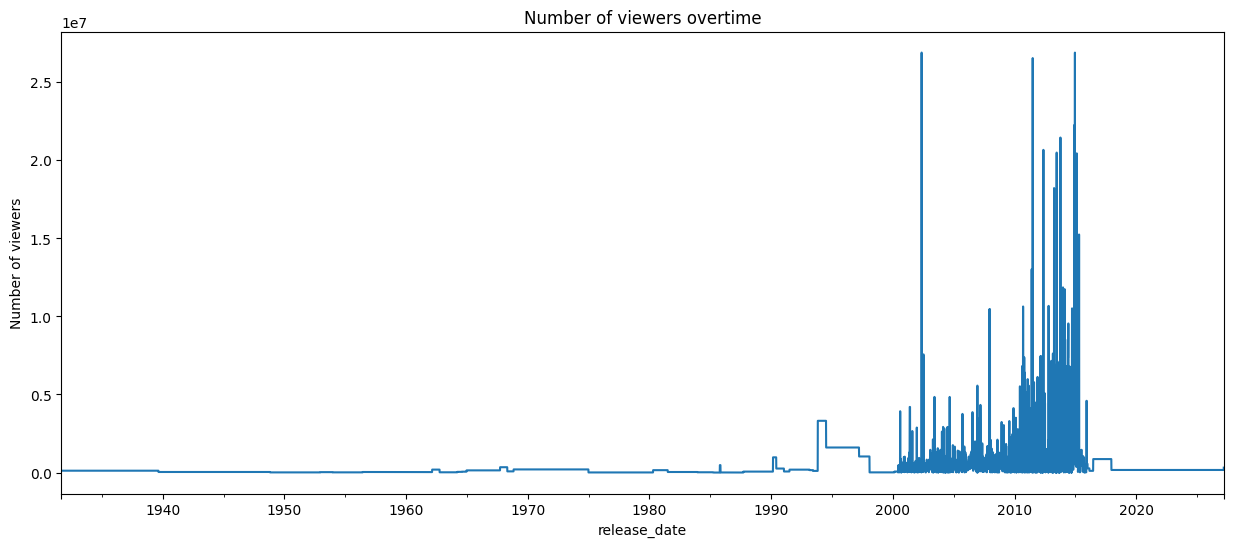

In [4]:
# Select the two columns
df_selected = df_1[['release_date', 'overall_views']].set_index('release_date')
#Resample to 1H window, forward fill missing values
df_selected = df_selected['overall_views'].resample("D").mean().fillna(method="ffill").to_frame()
# Plot as line chart
fig, ax = plt.subplots(figsize=(15, 6))
df_selected["overall_views"].plot(xlabel="release_date", ylabel="Number of viewers", title="Number of viewers overtime", ax=ax);

<Axes: title={'center': 'Weekly Rolling Average of viewers'}, xlabel='release_date', ylabel='Number of viewers'>

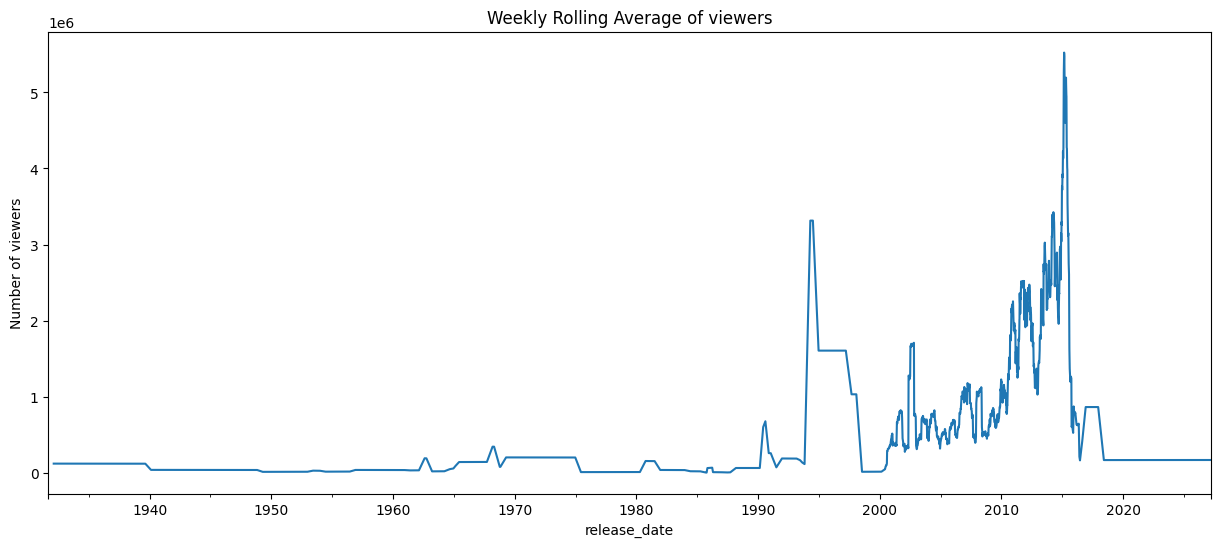

In [5]:
fig, ax = plt.subplots(figsize=(15, 6))

df_selected["overall_views"].rolling(168).mean().plot(ax=ax, ylabel= "Number of viewers", title = "Weekly Rolling Average of viewers")

The function below is designed to engineer new features that will be introduced into the model for more extensive checks of potentially predictive combinations. These functions take the wrangle function as input. Additionally, they drop high cardinality features that may be meaningless to the model, as well as leaky features, i.e., features that already exist under a different name in the dataset.

In [6]:
# Function to add new engineered feature to the data set
def new_feature(filename):
    # recalling the wrangle function
    df = wrangle(filename)
    # Release and Timing Features
    #df['days_to_dvd_release'] = (df['dvd_release_date'] - df['release_date']).dt.days
    df['month_to_dvd_release'] = (df['dvd_release_date'].dt.year - df['release_date'].dt.year) * 12 + (df['dvd_release_date'].dt.month - df['release_date'].dt.month)

    # Extract month and year as string
    df['release_month'] = df['release_date'].dt.strftime('%b')
    # Define the correct order for the months
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    # Convert the release_month column to a categorical type with the correct order
    df['release_month'] = pd.Categorical(df['release_month'], categories=month_order, ordered=True)
    #df['release_year'] = df['release_date'].dt.strftime('%Y')
    df['release_quarter'] = 'Q' + df['release_date'].dt.quarter.astype(str)

    # Engagement Features
    df['total_interactions'] = df['likes'] + df['comments'] + df['dislikes']
    df['engagement_ratio'] = df['total_interactions'] / df['overall_views']

    # User Feedback Features
    df['positive_feedback'] = df['likes'] + df['comments']
    df['negative_feedback'] = df['dislikes'] +  df['comments']
    df['feedback_ratio'] = df['positive_feedback'] / df['negative_feedback']

    # Award-related Features
    df['award_nomination_win_ratio'] = df['awards_win'] / df['awards_nomination']

    # Genre, Language and Country-related Features
    df['number_of_genres'] = df['genres'].str.count(',') + 1
    df['number_of_languages'] = df['language'].str.count(',') + 1
    df['number_of_countries'] = df['country'].str.count(',') + 1

    # List of columns called substrings recommended to be dropped
    substrings = ["total_interactions", 'positive_feedback',
                  'negative_feedback', 'release_date', 'dvd_release_date']

    #drop loop function
    drop_cols = [col for col in df.columns if any(sub in col for sub in substrings)]

    #Drop highly identical/ Leaky and high/ low cardinality columns
    df.drop(columns = drop_cols, inplace = True)

    return df

## Exploratory Data Analysis

I executed the `new_feature function` to facilitate exploratory data analysis (EDA) and subsequent model training on both the train and test datasets, with a primary focus on the train CSV file. After processing, the train CSV data now contains 28 columns, which includes 5 additional columns introduced by the function. The examination of this data reveals a significant amount of incomplete data and missing values, indicating an imbalanced dataset. This underscores the appropriateness of using Gradient Boosting as a model capable of effectively addressing such challenges.

In [7]:
## Entry of the dataset to fill in more features
df = new_feature("train.csv") ## train csv
df_2 = new_feature("test.csv") ## test csv
print(df.shape)
df.info()

<ipython-input-2-e654fdd36a10>:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['release_date'] = df['release_date'].fillna(method='ffill')
<ipython-input-2-e654fdd36a10>:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['dvd_release_date'] = df['dvd_release_date'].fillna(method='ffill')
<ipython-input-2-e654fdd36a10>:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['release_date'] = df['release_date'].fillna(method='ffill')
<ipython-input-2-e654fdd36a10>:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['dvd_release_date'] = df['dvd_release_date'].fillna(method='ffill')


(2400, 28)
<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, M  to Close 
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   country                     2400 non-null   object  
 1   genres                      2400 non-null   object  
 2   language                    2395 non-null   object  
 3   writer_count                2306 non-null   float64 
 4   title_adaption              2400 non-null   object  
 5   censor_rating               2362 non-null   object  
 6   runtime                     2400 non-null   float64 
 7   users_votes                 2400 non-null   float64 
 8   comments                    1974 non-null   float64 
 9   likes                       1956 non-null   float64 
 10  overall_views               2083 non-null   float64 
 11  dislikes                    1956 non-null   float64 
 12  ratings_imdb                2400 non-null   float64 
 13  ratings_t

**Additional Data Cleaning and Error Handling**

After adding new features, many parts of the dataset contained missing values, resulting in faulty calculations that produced meaningless values like `inf` or `NaNs`, which are problematic for model operation. The code below addresses these errors by replacing `inf` with blanks, which can be better re-imputed during the model fitting phase.

Additionally, float data types were reduced to 2 decimal places to manage the lengthy values resulting from the new features. The `describe` function was used to check the computational showcase of the dataset, ensuring that the error handling was effective. It also provides descriptive statistics of numerical features in the dataset, offering insights into their respective distributions.

For Instance:
* Writer Count: contains movies with up to 28 writers, with a mean of approximately 2.60 writers per movie. The distribution is right-skewed, as the median is 2 and the 75th percentile is 3, suggesting that most movies have a few writers, but some have significantly more.
* Runtime: Movie runtimes vary widely, from 38 minutes to 566 minutes, with an average of about 106 minutes. The 25th to 75th percentile range (93 to 115 minutes) shows a relatively compact distribution around the median of 102 minutes, indicating that most movies have a runtime close to the average.
* User Votes: The number of user votes ranges from 55 to over 2 million, with a mean of 83,000 votes. This large standard deviation (149,000) indicates high variability, with many movies receiving relatively few votes while a few receive a very high number.
* Overall Views: The views range from 0 to 188,526, with a mean of about 3,114 views. The distribution is heavily right-skewed, with a large standard deviation (10,214), indicating that while most movies have relatively low view counts, a few have extremely high viewership.

In [8]:
# Replace infinite values and large values in the dataset
df.replace([np.inf, -np.inf], '', inplace=True)
df_2.replace([np.inf, -np.inf], '', inplace=True)

# Round all float columns to 2 decimal places
df = df.round({col: 2 for col in df.select_dtypes(include=['float64']).columns})
df_2 = df_2.round({col: 2 for col in df_2.select_dtypes(include=['float64']).columns})

In [9]:
df.describe()

,writer_count,runtime,users_votes,comments,likes,overall_views,dislikes,ratings_imdb,ratings_tomatoes,ratings_metacritic,special_award,awards_win,awards_nomination,month_to_dvd_release,engagement_ratio,number_of_genres,number_of_languages,number_of_countries
count,2306.000000,2400.00000,2.400000e+03,1974.000000,1956.000000,2.083000e+03,1956.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,1929.000000,2400.000000,2395.000000,2400.000000
mean,2.596271,105.88250,8.295868e+04,546.438197,3113.894172,1.345472e+06,232.665644,6.493917,0.568546,53.775417,0.185417,6.582917,12.698333,10.535833,0.000845,2.823333,1.670564,1.660000
std,2.011586,20.62428,1.486881e+05,2103.833164,10213.600411,4.030918e+06,946.288417,0.999590,0.281484,21.002570,0.388716,16.089857,24.925965,51.620416,0.002980,1.228584,1.152360,1.143071
min,1.000000,38.00000,5.500000e+01,0.000000,0.000000,2.100000e+01,0.000000,1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,-289.000000,0.000000,1.000000,1.000000,1.000000
25%,1.000000,93.00000,6.706750e+03,10.000000,99.000000,6.752950e+04,7.000000,5.900000,0.340000,41.000000,0.000000,0.000000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000
50%,2.000000,102.00000,2.851300e+04,57.000000,425.000000,2.816520e+05,30.000000,6.600000,0.620000,56.000000,0.000000,2.000000,5.000000,4.000000,0.000000,3.000000,1.000000,1.000000
75%,3.000000,115.00000,9.308625e+04,289.000000,1819.000000,9.855095e+05,121.250000,7.200000,0.820000,69.000000,0.000000,6.000000,12.000000,6.000000,0.000000,4.000000,2.000000,2.000000
max,28.000000,566.00000,2.070977e+06,44644.000000,188526.000000,1.071502e+08,29267.000000,9.000000,1.000000,100.000000,1.000000,235.000000,326.000000,806.000000,0.040000,8.000000,18.000000,19.000000


The line chart below shows the release of movies counts per months, October and August has shown the highest release period respectively as seen below.

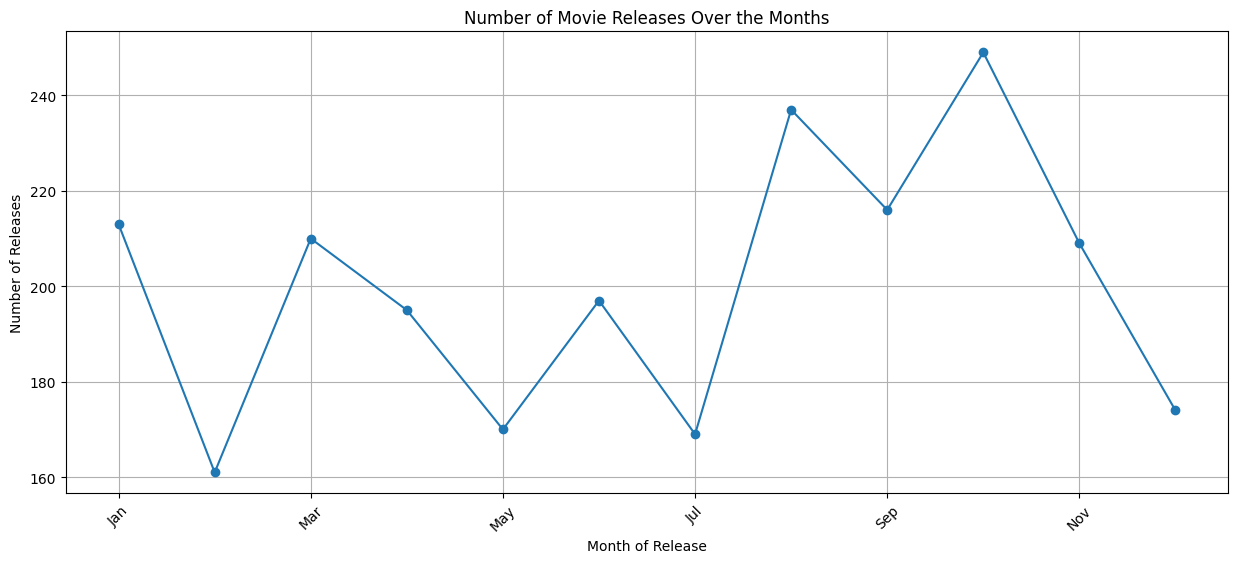

In [10]:
# Trend of movie releases over the months
# Group by month and count the number of releases
monthly_releases = df['release_month'].value_counts().sort_index()

# Plot the trend of movie releases over the months
plt.figure(figsize=(15, 6))
monthly_releases.plot(kind='line', marker='o')
plt.title('Number of Movie Releases Over the Months')
plt.xlabel('Month of Release')
plt.ylabel('Number of Releases')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

The boxplot chart below illustrates the distribution of user votes and overall views categorized by revenue. User votes exhibit greater visibility in the high revenue category compared to overall views. Both data sets are skewed.

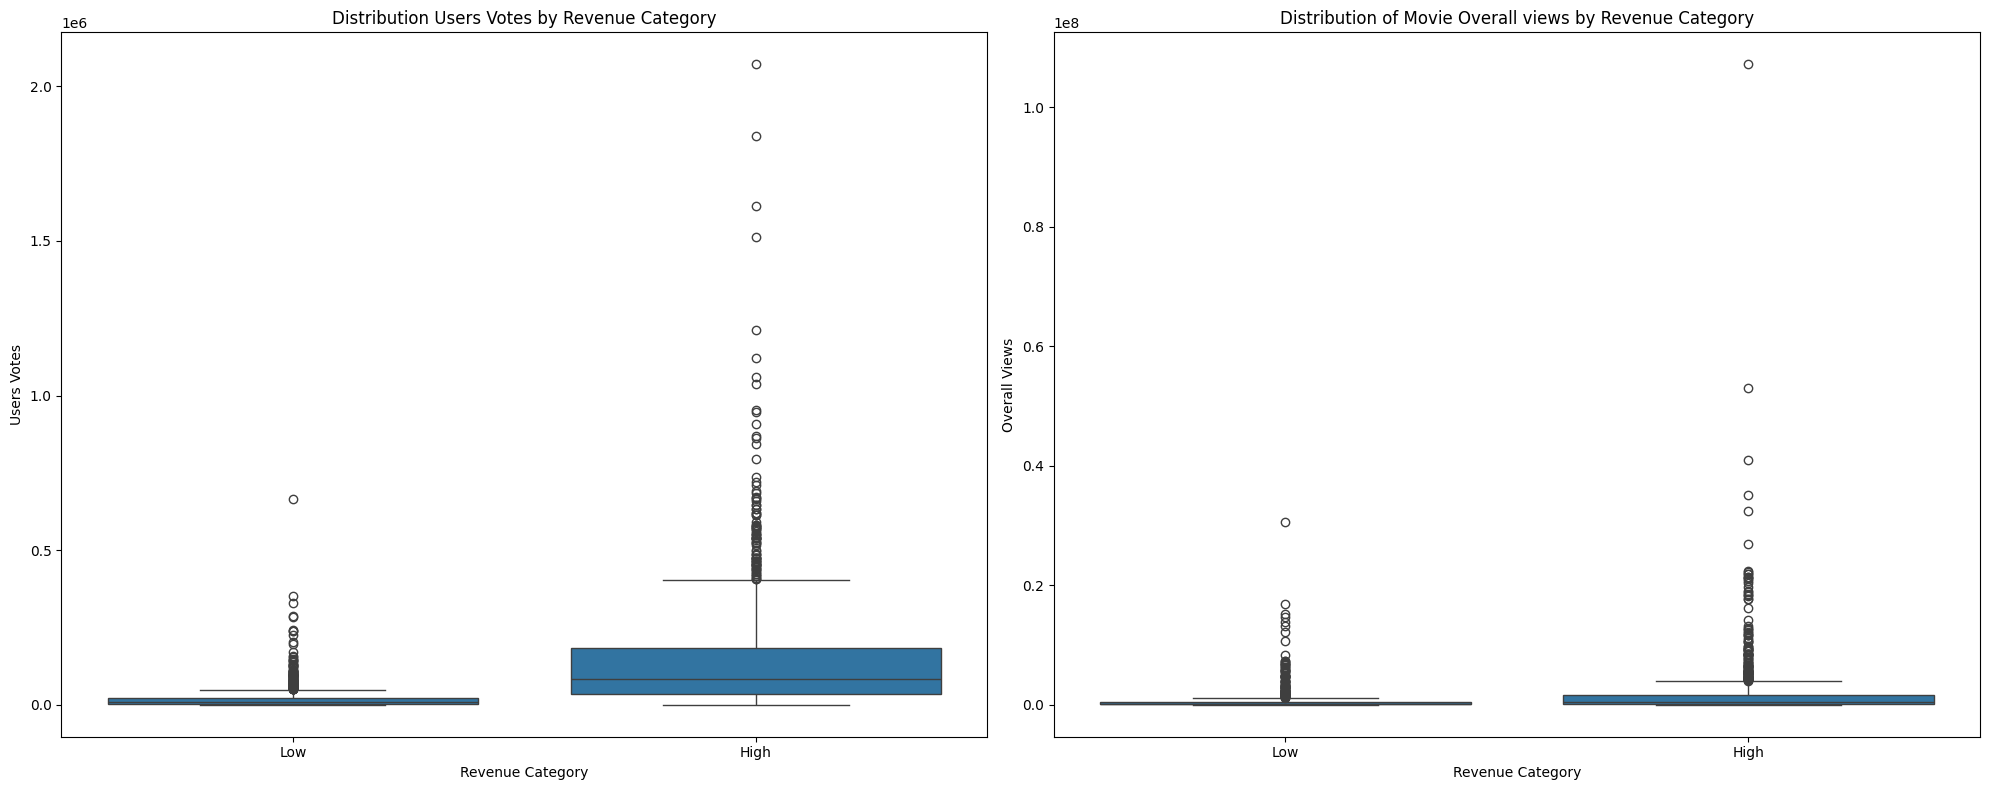

In [11]:
df_n = df.reset_index(drop=True)

# Now try plotting again
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plotting users vote distribuion
sns.boxplot(df_n, x="revenue_category", y="users_votes", ax=axes[0])
axes[0].set_title("Distribution Users Votes by Revenue Category")
axes[0].set_xlabel("Revenue Category")
axes[0].set_ylabel("Users Votes")

#Ploting overall view distribution
sns.boxplot(df_n, x="revenue_category", y="overall_views", ax=axes[1])
axes[1].set_title('Distribution of Movie Overall views by Revenue Category')
axes[1].set_xlabel('Revenue Category')
axes[1].set_ylabel('Overall Views'),

plt.tight_layout()
plt.show()

The chart below displays the distribution of movie genres based on movie counts, highlighting how films are categorized by genre. Drama leads as the most common genre, followed by comedy and thriller. Since many movies in the dataset are associated with multiple genres, the data has been split and counted to reflect the number of movies associated with each genre.

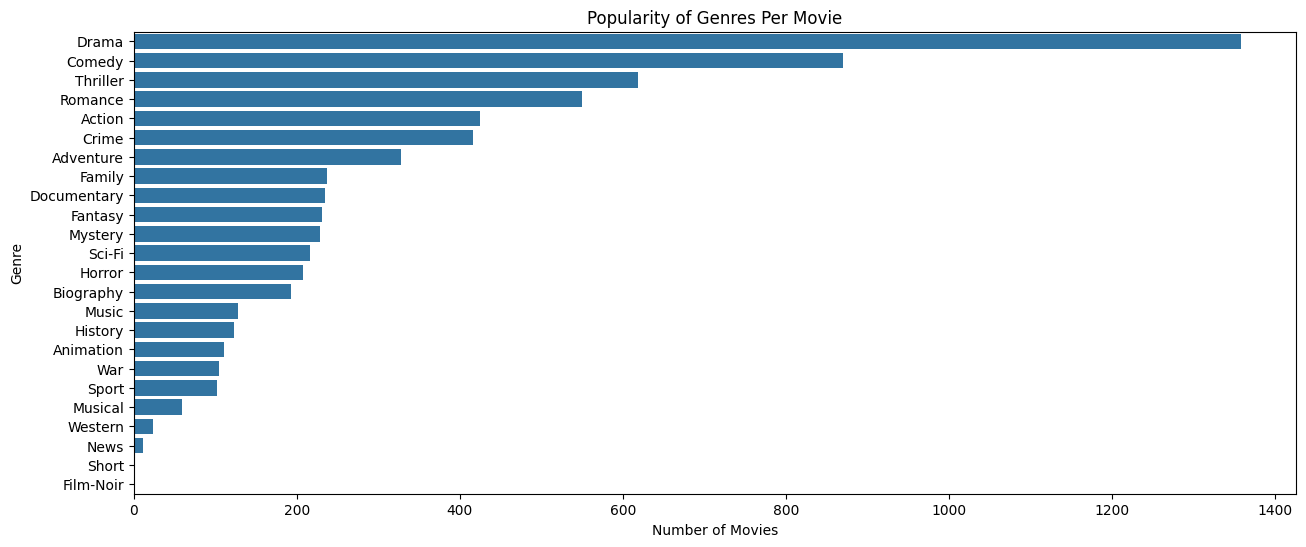

In [12]:
# Splitting genres and counting occurrences
genres_split = df['genres'].str.split(',', expand=True).stack().str.strip().reset_index(level=1, drop=True)
genres_count = genres_split.value_counts()

# Plotting genre counts
plt.figure(figsize=(15, 6))
sns.barplot(x=genres_count.values, y=genres_count.index)
plt.title('Popularity of Genres Per Movie')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

The analysis below examines the number of movies in the dataset based on their language and country distribution. The USA leads with the highest number of movies published in English, making it the most prevalent language.

To simplify the presentation of less common countries and languages, those with fewer than 40 movies or fewer than 50 movies, respectively, were grouped together under the category `Others`. This approach addresses the issue of high cardinality, where multiple countries and languages were mapped as lists, thus enhancing the chart's clarity and readability.

In [13]:
# Split the language column
languages_split = df['language'].str.split(',', expand=True).stack().str.strip().reset_index(level=1, drop=True)

# Count the occurrences of each language
language_counts = languages_split.value_counts().sort_values(ascending=False).to_frame(name='counts')

# Rename languages with counts less than 100 to 'Other'
language_counts['language'] = language_counts.index
language_counts.loc[language_counts['counts'] < 50, 'language'] = 'Other'

# Group by 'language' and sum the counts for 'Other'
language_counts = language_counts.groupby('language').sum().sort_values(by='counts', ascending=False)

# Display the resulting DataFrame
#language_counts

country_split = df['country'].str.split(',', expand=True).stack().str.strip().reset_index(level=1, drop=True)
country_counts = country_split.value_counts().sort_values(ascending = False)
country_split = df['country'].str.split(',', expand=True).stack().str.strip().reset_index(level=1, drop=True)
country_counts = country_split.value_counts().sort_values(ascending = False)

# Count the occurrences of each country
country_counts = country_split.value_counts().sort_values(ascending=False).to_frame(name='counts')

# Rename countries with counts less than 100 to 'Other'
country_counts['country'] = country_counts.index
country_counts.loc[country_counts['counts'] < 40, 'country'] = 'Other'

# Group by 'countries' and sum the counts for 'Other'
country_counts = country_counts.groupby('country').sum().sort_values(by='counts', ascending=False)

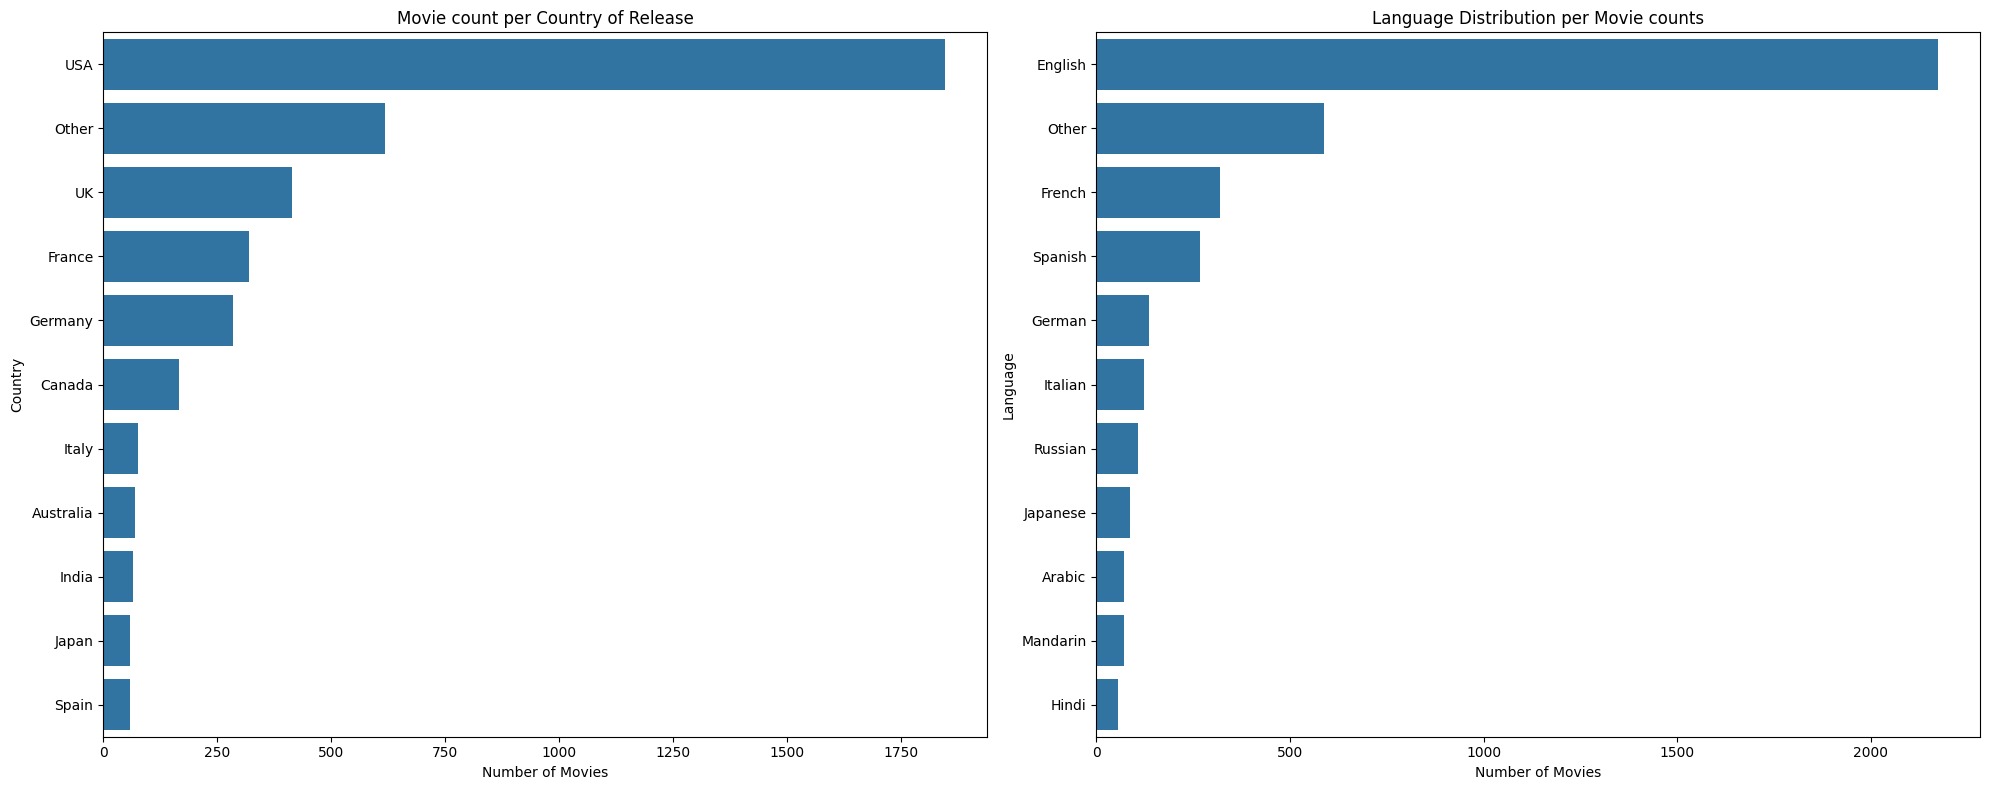

In [14]:
# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plotting country by movie counts
sns.barplot(x=country_counts['counts'], y=country_counts.index, ax=axes[0])
axes[0].set_title('Movie count per Country of Release')
axes[0].set_xlabel('Number of Movies')
axes[0].set_ylabel('Country')

#Ploting language by count
sns.barplot(x=language_counts['counts'], y=language_counts.index)
axes[1].set_title('Language Distribution per Movie counts')
axes[1].set_xlabel('Number of Movies')
axes[1].set_ylabel('Language')

plt.tight_layout()
plt.show()


The chart below presents a correlation heatmap depicting the relationships among numerical variables in the dataset. Lighter colors indicate strong correlations ranging from 0.55 to 0.99, while darker colors represent weaker or no correlations, ranging from 0.45 to 0.19. The heatmap reveals both numerous uncorrelated factors and some highly correlated ones. This suggests the need for a model capable of handling such non-linearity.

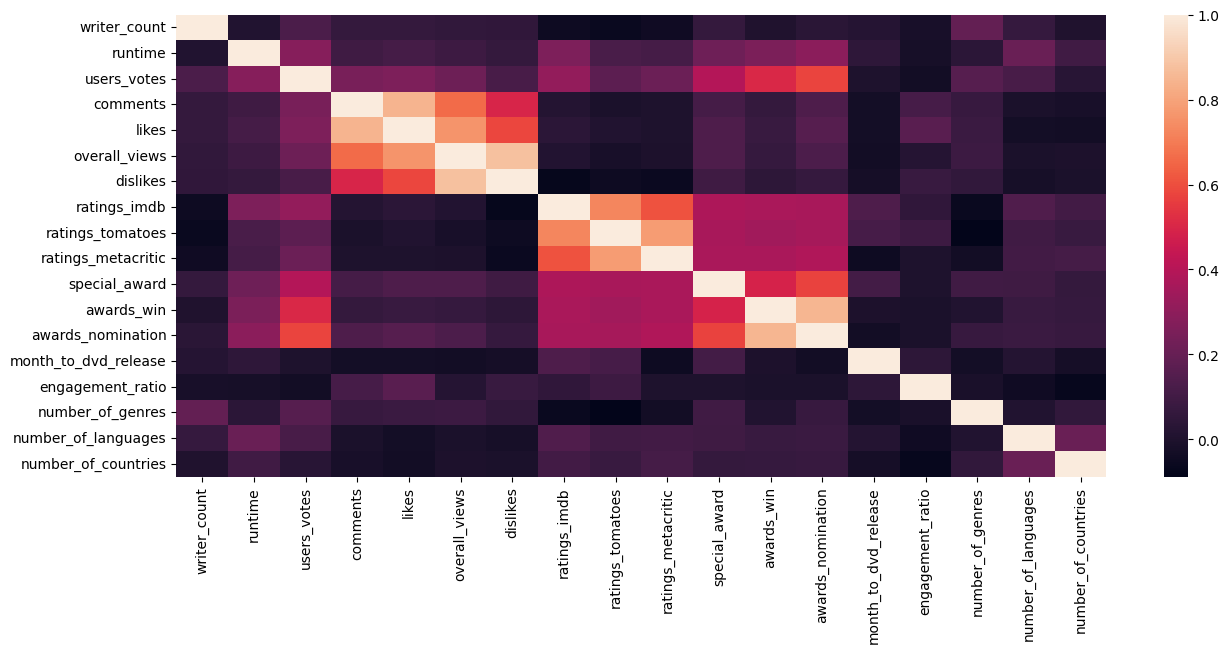

In [15]:
# Create correlation matrix
plt.figure(figsize=(15, 6))
correlation = df.select_dtypes("number").corr()
#correlation
# Plot heatmap of `correlation`
sns.heatmap(correlation);

The bar chart below displays the distribution of the target variable, `revenue_category`. The close distribution of both classes, particularly in the training data, is reassuring. This balance helps ensure that the model is less likely to encounter biases during training.

<Axes: title={'center': 'Class Balance'}, xlabel='class', ylabel='Relative Frequency'>

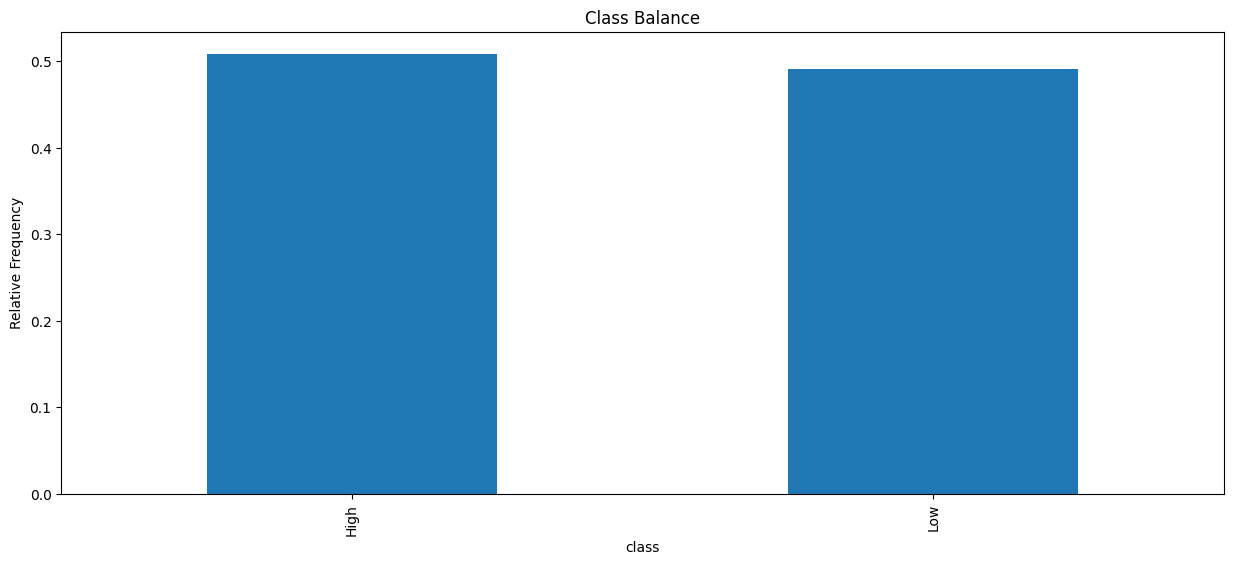

In [16]:
# Plot value counts of `"revenue category"`
plt.figure(figsize=(15, 6))
df["revenue_category"].value_counts(normalize=True).plot(
  kind='bar', xlabel="class", ylabel="Relative Frequency", title="Class Balance"
)

## Data Splitting

In this section, the dataset is organized to align with the model's requirements. This involves splitting the training data into training and test/validation sets. Additionally, the test data is prepared with a new name for clarity as `test_df`, and all categorical columns are converted to strings to ensure consistent treatment as categorical data.

In [17]:
target = "revenue_category"
X = df.drop(columns=target)
y = df[target]
test_df = df_2

print("X shape:", X.shape)
print("y shape:", y.shape)
print("test_df shape:", test_df.shape)

X shape: (2400, 27)
y shape: (2400,)
test_df shape: (600, 27)


In [18]:
# Ensure all categorical columns are of type 'object'
for col in X.select_dtypes(include=['object', 'bool']).columns:
    X[col] = X[col].astype(str)
    test_df[col] = test_df[col].astype(str)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1920, 27)
y_train shape: (1920,)
X_test shape: (480, 27)
y_test shape: (480,)


# Model Building

In this section, we first establish an accuracy baseline to set expectations for model performance. Achieving and surpassing this baseline is crucial, as it indicates that the model is performing effectively.

## Baseline

In [20]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.5099


## Iterate Process

In this iteration, the model criteria were implemented as follows:
1. Separate preprocessing for numeric and categorical features:
    * **Numeric features:** Imputed using the median strategy and scaled using StandardScaler.
    * **Categorical features:** Imputed using the most_frequent strategy (mode) and encoded using OneHotEncoder.
    * **ColumnTransformer:** Integrates the preprocessing pipelines for both numeric and categorical features.


2. Handle Missing Values: Impute missing values in categorical columns before encoding them with OneHotEncoder.

3. Preprocessing and Pipeline: Utilize ColumnTransformer to preprocess numeric and categorical features.
4. make_pipeline: Create a pipeline that includes the preprocessor and the GradientBoostingClassifier.
5. Parameter Grid (params): Define strategies for the imputer and hyperparameters for the GradientBoostingClassifier.
6. GridSearchCV: Conduct hyperparameter tuning using the parameter grid, which includes strategies for numeric imputer.

In [21]:
# Preprocessing pipeline
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the pipeline using make_pipeline
clf = make_pipeline(preprocessor, GradientBoostingClassifier())

In [22]:
# Define the parameter grid
params = {
    'columntransformer__num__imputer__strategy': ['mean', 'median'],
    'columntransformer__cat__imputer__strategy': ['most_frequent', 'constant'],
    'gradientboostingclassifier__n_estimators': range(20, 31, 5),
    'gradientboostingclassifier__max_depth': range(2, 5)\
}
params

{'columntransformer__num__imputer__strategy': ['mean', 'median'],
 'columntransformer__cat__imputer__strategy': ['most_frequent', 'constant'],
 'gradientboostingclassifier__n_estimators': range(20, 31, 5),
 'gradientboostingclassifier__max_depth': range(2, 5)}

In [23]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['writer_count', 'runtime', 'users_votes', 'comments', 'likes',
       'overall_views', 'dislikes', 'ratings_imdb', 'ratings_tomatoes',
       'ratings_metacritic', 'special_award', 'awards_w...
      dtype='object'))])),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'columntransformer__cat__imputer__strategy': ['most_frequent',
                                                                       'constant'],
                         'columntransformer__num__imputer__strategy': ['mean',
                                                                       'median'],
                         'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5)},
             verbose=1)

In [24]:
# Train model
model.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['writer_count', 'runtime', 'users_votes', 'comments', 'likes',
       'overall_views', 'dislikes', 'ratings_imdb', 'ratings_tomatoes',
       'ratings_metacritic', 'special_award', 'awards_w...
      dtype='object'))])),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'columntransformer__cat__imputer__strategy': ['most_frequent',
                                                                       'constant'],
                         'columntransformer__num__imputer__strategy': ['mean',
                                                                       'median'],
                         'gradientboostingclassifier__max_depth': range(2, 5),
                         'gradientboostingclassifier__n_estimators': range(20, 31, 5)},
             verbose=1)

In [25]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_columntransformer__cat__imputer__strategy,param_columntransformer__num__imputer__strategy,param_gradientboostingclassifier__max_depth,param_gradientboostingclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
35,1.250021,0.146367,0.049297,0.011568,constant,median,4,30,{'columntransformer__cat__imputer__strategy': ...,0.872396,0.848958,0.864583,0.859375,0.885417,0.866146,0.012281,1
26,1.264875,0.250942,0.044386,0.014104,constant,mean,4,30,{'columntransformer__cat__imputer__strategy': ...,0.872396,0.841146,0.869792,0.861979,0.877604,0.864583,0.012758,2
8,0.923708,0.183120,0.030877,0.000681,most_frequent,mean,4,30,{'columntransformer__cat__imputer__strategy': ...,0.872396,0.846354,0.861979,0.864583,0.875000,0.864062,0.010072,3
17,1.508056,0.143556,0.078921,0.033407,most_frequent,median,4,30,{'columntransformer__cat__imputer__strategy': ...,0.872396,0.846354,0.859375,0.856771,0.880208,0.863021,0.011945,4
16,1.116418,0.093128,0.054282,0.014153,most_frequent,median,4,25,{'columntransformer__cat__imputer__strategy': ...,0.861979,0.848958,0.864583,0.859375,0.875000,0.861979,0.008398,5


**Training Time vs. Max Depth Plot**

The plot below illustrates the relationship between training time and maximum depth for the best model with `n_estimators=30`:

The plot shows a nearly linear relationship between maximum depth (`max_depth`) and mean fit time (training time). As `max_depth` increases, the training time also rises linearly.
A `max_depth` of approximately 4 results in the longest training time (nearly 4 seconds), whereas a `max_depth` of about 2 results in the shortest training time (around 2 seconds). This indicates that while deeper trees may better capture complex patterns, they also demand more computational resources.

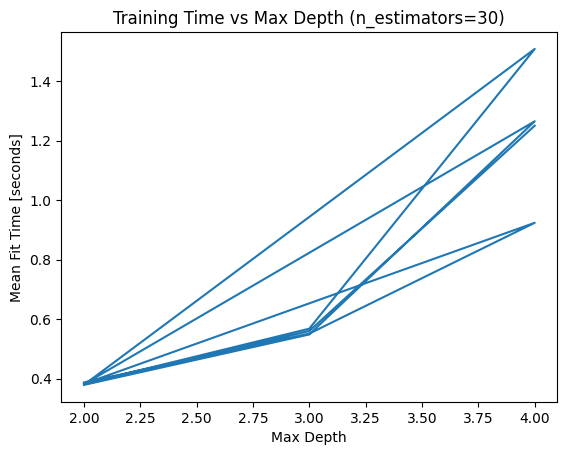

In [26]:
# Create mask
mask = cv_results["param_gradientboostingclassifier__n_estimators"]==30
# Plot fit time vs n_estimators
plt.plot(
cv_results[mask]["param_gradientboostingclassifier__max_depth"],
cv_results[mask]["mean_fit_time"]
)
# Label axes
plt.xlabel("Max Depth")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Max Depth (n_estimators=30)");

In [27]:
# Extract best hyperparameters
model.best_params_

{'columntransformer__cat__imputer__strategy': 'constant',
 'columntransformer__num__imputer__strategy': 'median',
 'gradientboostingclassifier__max_depth': 4,
 'gradientboostingclassifier__n_estimators': 30}

In [28]:
model.best_estimator_

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['writer_count', 'runtime', 'users_votes', 'comments', 'likes',
       'overall_views', 'dislikes', 'ratings_imdb', 'ratings_tomatoes',
       'ratings_metacritic', 'special_award', 'awards_win',
       'awards...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['country', 'genres', 'language', 'title_adaption', 'censor_rating',
       'release_quarter', 'feedback_ratio', 'award_nomination_win_ratio'],
      dtype='object'))])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=4, n_estimators=30))])

## Model Evaluation

In this phase, the model's performance was assessed using the following methods:
* **Accuracy Metric:** sDemonstrates that both the training and validation accuracy surpass the baseline, indicating strong overall performance.
* **Classification report:** Offers a detailed overview of precision, recall, and F1 score for each class, providing a comprehensive evaluation of the model's performance and highlighting its strengths and weaknesses in various areas.
* Additionally, the **Confusion Matrix** Visualizes the classification report, offering a customizable display to accommodate different use cases the organization might consider.

In [29]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9052
Validation Accuracy: 0.8688


**Model Perfomance:** The slight drop from training accuracy (90.52%) to validation accuracy (86.67%) is expected and indicates that the model generalizes well without overfitting.

**Class Performance:**
* In the **High Revenue Category**,
    * Precision(0.84): 84% of the movies predicted to have high revenue actually did, showing the proportion of true positive predictions among all positive predictions.
    * Recall (0.90): 88% of the movies that actually had high revenue were correctly identified by the model, reflecting the model's ability to identify true positives from all actual positives.

* Also in the **Low revenue category**;
    * Precision(0.89): 89% of the movies predicted to have low revenue indeed had low revenue, showing the proportion of true negative predictions among all negative predictions.
    * Recall (0.83): 83% of the movies that actually had low revenue were correctly identified by the model, indicating the model's ability to identify true negatives from all actual negatives.

**Other metrics:**
* F1-Score: is the harmonic mean of precision and recall , providing a balance between the two.
* Support shows the number of actual instances of high and low clasa in the test/ validation set.
* The macro average and weighted average metrics are equal, further indicating that the model's performance is consistent across both classes.

In [30]:
# Print classification report
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

        High       0.85      0.90      0.87       242
         Low       0.90      0.83      0.86       238

    accuracy                           0.87       480
   macro avg       0.87      0.87      0.87       480
weighted avg       0.87      0.87      0.87       480



**Confusion Matrix Analysis**

The confusion matrix below provides a static representation of the best model parameters selected for this exercise.

Note that "Negative" (N) represents the `High` revenue category, and "Positive" (P) represents the `Low` revenue category.

This chart indicates that the model moderately predicted more True Negatives (TN) and True Positives (TP), and fewer False Negatives (FN) and False Positives (FP). This explains why both recall and precision values are very close. The use of these metrics will be further examined in the customized display.

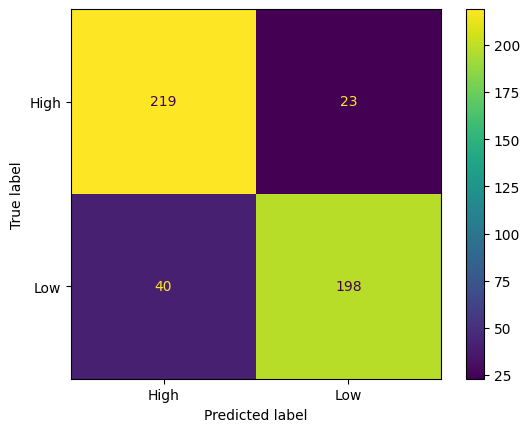

In [31]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

**Custom Confusion Matrix Display**

The customized confusion matrix display below was created using a locally installed widget library, allowing for an interactive view of the classification metric behavior across a probability threshold range of 0.0 to 1.0.

* As the threshold is reduced, recall increases, as does the number of false positives (FP), meaning the model will predict more movies in the low revenue category, but its precision (correctness) decreases.
* Conversely, as the threshold is increased, precision rises and false positives decrease, resulting in more movies being predicted in the high revenue category.
* Throughout these threshold adjustments, the model maintains a very good accuracy score.

* In other to fulfil the objective of Watch-It management, increasing the precision threshold is best, to enables the model to predict more movies in the high revenue category.
  
A scenerio example is shown in the second confusion matrix
* Returns on investment for correctly predicted high revenue movies are calculated as `ROI on Licenses`.
* Returns on investment for wrongly predicted presumed high revenue movies are labeled as `False ROI`.
* Returns on investment for wrongly predicted presumed low revenue movies are labeled as `Missed ROI`.

In [32]:
def plot_confusion_matrices(threshold):
    # Predict probabilities for the test data
    y_pred_proba = model.predict_proba(X_test)[:, -1]

    # Apply the threshold to get binary class predictions
    y_pred_binary = y_pred_proba > threshold

    # Map the binary predictions to custom labels
    y_pred_labels = np.where(y_pred_binary, 'Low', 'High')

    # Map 'Low' to False and 'High' to True
    y_test_mapped = y_test.map({'High': False, 'Low': True})

    # Ensure y_test_mapped contains 'High' and 'Low'
    y_test_labels = np.where(y_test_mapped == 1, 'Low', 'High')

    # Compute the confusion matrix with custom labels
    conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=['High', 'Low'])

    # Extract the values from the confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()

    # Calculate accuracy, precision, and recall
    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    precision = precision_score(y_test_labels, y_pred_labels, pos_label='Low')
    recall = recall_score(y_test_labels, y_pred_labels, pos_label='Low')

    # Create the subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot the confusion matrix with custom ROI metrics
    ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, display_labels=['High', 'Low'], colorbar=False, ax=axes[0])
    axes[0].set_title('Confusion Matrix with Custom ROI Metrics')
    axes[0].text(0.5, 0.9, f"ROI on Licenses: ₦{tn * 5_000}\nMissed ROI : ₦{fp * 5_000}\nFalse ROI : ₦{fn * 5_000}"
                 ,ha='center', va='center', transform=axes[0].transAxes, fontsize=12, color="#FF00FF", verticalalignment='top'
                )

    # Plot the confusion matrix with accuracy, precision, and recall
    ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, display_labels=['High', 'Low'], colorbar=False, ax=axes[1])
    axes[1].set_title('Confusion Matrix with Accuracy, Precision, and Recall')
    axes[1].text(0.5, 0.9, f"Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}"
                 ,ha='center', va='center', transform=axes[1].transAxes, fontsize=12, color="#FF00FF", verticalalignment='top'
                )

    # Display the plots
    plt.show()

# Create the threshold slider widget
thresh_widget = widgets.FloatSlider(min=0, max=1, value=0.5, step=0.05)

# Use the interact function to create an interactive widget
interact(plot_confusion_matrices, threshold=thresh_widget)

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.05), Output()), _dom_cla…

<function __main__.plot_confusion_matrices(threshold)>

## Communication of Model Results

**Feature Importance Analysis**

In this section, the key features or factors contributing to the model's final output are outlined as follows:
* Extracting Feature Importances: The `feature_importances_` attribute of the trained GradientBoostingClassifier was accessed.
* Getting Feature Names: oth numeric and categorical feature names were combined. For categorical features, `get_feature_names_out` was used to obtain encoded feature names.
* Create DataFrame: A DataFrame was created with feature names and their corresponding importances.
* Sort and Plot: The DataFrame was sorted by importance and  top 10 features was plotted using Seaborn's barplot.

The chart below reveals that `user votes` have the highest importance on the model's output/predictions, followed by `IMDb ratings` and `Censors Rating Unrated`

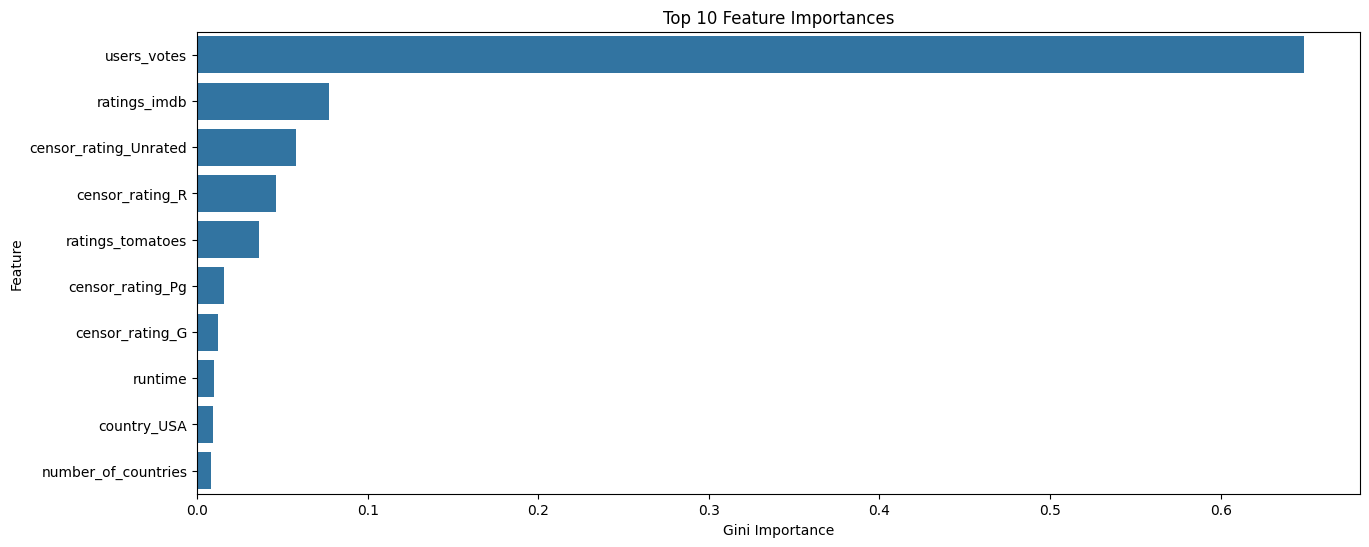

In [33]:
# Extract feature importances
best_gb_model = model.best_estimator_
feature_importances = best_gb_model.named_steps['gradientboostingclassifier'].feature_importances_

# Get the feature names from the preprocessor
feature_names_num = numeric_features.tolist()
feature_names_cat = best_gb_model.named_steps['columntransformer'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
feature_names = feature_names_num + feature_names_cat

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)  # Get top 10 features

# Plot the feature importances
plt.figure(figsize=(15, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 10 Feature Importances')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.show()

## Generating Predictions for Watch-It Media

In this section, the test CSV file is used to generate prediction outputs for Watch-It Media. The process is outlined as follows:
* Save Model: The model was saved to ensure reproducibility, allowing it to be accessed whenever needed.
* Make Prediction Function: This function was developed to accept the model and the data file, handle preparation and feature engineering, and then generate predictions.
* Predicted file:  The predictions are written to a CSV file, making them available for distribution as needed.

In [34]:
# Save model
with open("watch-it_model.pkl", "wb") as f:
    pickle.dump(model,f)

In [ ]:
def make_predictions(data_filepath, model_filepath):
    # Wrangle JSON file
    X_test = new_feature(data_filepath)
    # Load model
    with open(model_filepath, "rb") as f:
        model = pickle.load(f)
    # Generate predictions
    y_test_pred = model.predict(X_test)
    # Put predictions into Series with name "revenue", and same index as X_test
    y_test_pred = pd.Series(y_test_pred, index=X_test.index, name="revenue_category")
    return y_test_pred

In [ ]:
#to use the threshold that support high precision for predictions
def predict_with_threshold(data_filepath, threshold,model_filepath):
    # Wrangle JSON file
    X_test = new_feature(data_filepath)
    # Load model
    with open(model_filepath, "rb") as f:
        model = pickle.load(f)
    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)

    # Apply the threshold
    y_pred_custom = (y_pred_proba[:, 1] >= threshold)
    # Map the binary predictions to custom labels
    y_pred_labels = np.where(y_pred_custom == 1, 'Low', 'High')
    # Put predictions into Series with name "revenue", and same index as X_test
    y_pred_custom = pd.Series(y_pred_labels, index=X_test.index, name="revenue_category")
    return y_pred_custom

In [ ]:
y_test_pred = make_predictions(
    data_filepath="test.csv",
    model_filepath="watch-it_model.pkl",
)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()

predictions shape: (600,)


<ipython-input-2-3f0b1564407c>:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['release_date'] = df['release_date'].fillna(method='ffill')
<ipython-input-2-3f0b1564407c>:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['dvd_release_date'] = df['dvd_release_date'].fillna(method='ffill')


title
Delhi-6                           Low
Before I Disappear                Low
Good Year, A                     High
Brüno                            High
How to Lose a Guy in 10 Days     High
Name: revenue_category, dtype: object

In [ ]:
y_test_custom_pred = predict_with_threshold(
    data_filepath="test.csv",
    threshold= 0.80,
    model_filepath="watch-it_model.pkl",
)

print("predictions shape:", y_test_custom_pred.shape)
y_test_custom_pred.head()

predictions shape: (600,)


<ipython-input-2-3f0b1564407c>:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['release_date'] = df['release_date'].fillna(method='ffill')
<ipython-input-2-3f0b1564407c>:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['dvd_release_date'] = df['dvd_release_date'].fillna(method='ffill')


title
Delhi-6                           Low
Before I Disappear                Low
Good Year, A                     High
Brüno                            High
How to Lose a Guy in 10 Days     High
Name: revenue_category, dtype: object

In [ ]:
print(type(y_test_pred))

<class 'pandas.core.series.Series'>


In [ ]:
# Convert the Series to a DataFrame
y_test_custom_pred = y_test_custom_pred.reset_index()
y_test_custom_pred.columns = ['title', 'revenue_category']

# Save the DataFrame to a CSV file
y_test_custom_pred.to_csv('submission_custom.csv', index=False)

In [ ]:
# Convert the Series to a DataFrame
y_pred_test_df = y_test_pred.reset_index()
y_pred_test_df.columns = ['title', 'revenue_category']

# Save the DataFrame to a CSV file
y_pred_test_df.to_csv('submissions.csv', index=False)

## END